In [1]:
# Import modules
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
import torch # torch 1.12.1
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Set random seed and device
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# Define hyperparameters
hyperparameters = {
    "seed": 45,
    "data_name": "toy_classification_aware2.csv",
    "data_path": "./data/",
    "batch_size": 8,
    "learning_rate": 5e-4,
    "epochs": 300,
    "activation": "gelu",
    "hidden_size": [32, 32, 32, 32, 32, 32, 2],
    "dropout": 0.0,
    "colors": {0.0: "red", 1.0: "blue"},
}
hyperparameters["data_path"] += hyperparameters["data_name"]
print("Hyperparameters:", hyperparameters)

# Set seed
set_seed(hyperparameters["seed"])
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

Hyperparameters: {'seed': 45, 'data_name': 'toy_classification_aware2.csv', 'data_path': './data/toy_classification_aware2.csv', 'batch_size': 8, 'learning_rate': 0.0005, 'epochs': 300, 'activation': 'gelu', 'hidden_size': [32, 32, 32, 32, 32, 32, 2], 'dropout': 0.0, 'colors': {0.0: 'red', 1.0: 'blue'}}
Current device: cuda:3


Loading data from ./data/toy_classification_aware2.csv:   0%|          | 0/160 [00:00<?, ?it/s]

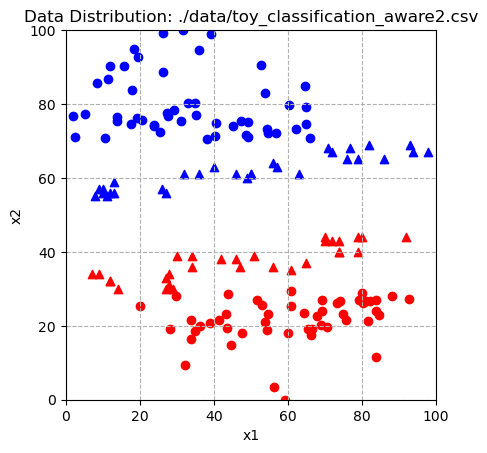

ToyModel(
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=32, out_features=32, bias=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=32, out_features=2, bias=True)
    (13): GELU(approximate='none')
  )
)


In [2]:
# Define the dataset
class ToyDataset(Dataset):
    def __init__(self, data_path: str) -> None:
        self.data_path = data_path
        self.dataframe = pd.read_csv(data_path)
        
        self.data_list = []
        for idx in tqdm(range(len(self.dataframe)), desc=f'Loading data from {data_path}'):
            self.data_list.append({
                'input': torch.tensor(self.dataframe.iloc[idx, 0:2].values, dtype=torch.float),
                'label': torch.tensor(int(self.dataframe.iloc[idx, 2]), dtype=torch.long),
                'index': idx
            })
        
        self.show_data()
    
    def __getitem__(self, index: int) -> dict:
        return self.data_list[index]
    
    def __len__(self) -> int:
        return len(self.data_list)

    def show_data(self) -> None:
        # Visualize the normalized data
        fig, ax = plt.subplots()
        for i in range(len(self.dataframe)):
            if self.dataframe.iloc[i, 3] == 0:
                ax.scatter(self.dataframe.iloc[i, 0], self.dataframe.iloc[i, 1],
                           c=hyperparameters["colors"][self.dataframe.iloc[i, 2]], marker="o")
            else:
                ax.scatter(self.dataframe.iloc[i, 0], self.dataframe.iloc[i, 1],
                           c=hyperparameters["colors"][self.dataframe.iloc[i, 2]], marker="^")
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_title(f"Data Distribution: {self.data_path}")
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        ax.set_aspect("equal")
        ax.grid(True, which="both", ls="--")
        plt.show()

# Define the model
class ToyModel(nn.Module):
    def __init__(self) -> None:
        super(ToyModel, self).__init__()
        self.linears = nn.ModuleList()

        for i in range(len(hyperparameters['hidden_size'])):
            if i == 0:
                self.linears.append(nn.Linear(2, hyperparameters['hidden_size'][i]))
            else:
                self.linears.append(nn.Linear(hyperparameters['hidden_size'][i-1], hyperparameters['hidden_size'][i]))
            
            if hyperparameters['activation'] == "relu":
                self.linears.append(nn.ReLU())
            elif hyperparameters['activation'] == "tanh":
                self.linears.append(nn.Tanh())
            elif hyperparameters['activation'] == "sigmoid":
                self.linears.append(nn.Sigmoid())
            elif hyperparameters['activation'] == "gelu":
                self.linears.append(nn.GELU())
            else:
                raise ValueError(f"Invalid activation function: {hyperparameters['activation']}")
            
            if hyperparameters['dropout'] > 0:
                self.linears.append(nn.Dropout(hyperparameters['dropout']))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.linears:
            x = layer(x)

        return x

# Initialize the dataset and model
dataset = ToyDataset(hyperparameters['data_path'])
model = ToyModel().to(device)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])

Training:   0%|          | 0/300 [00:00<?, ?it/s]

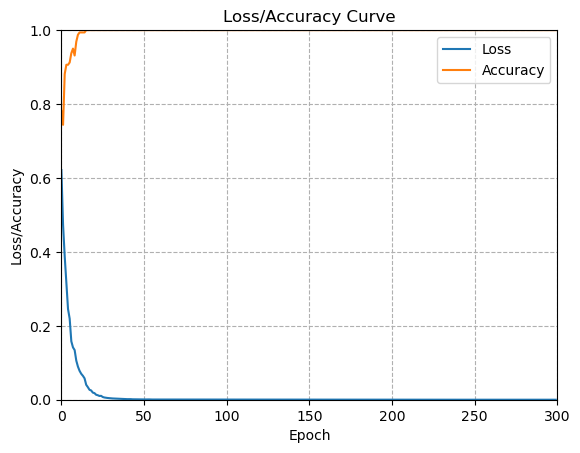

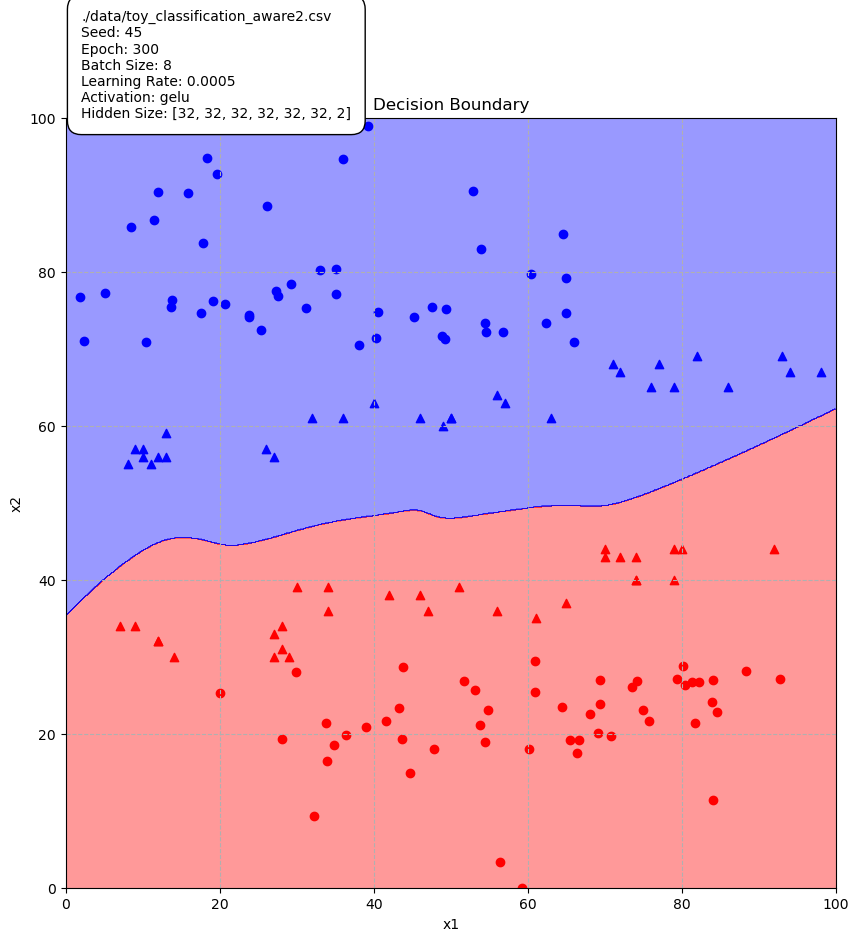

In [3]:
# Define the visualization function
def visualize_decision_boundary(model: nn.Module, device: torch.device) -> None:
    # Visualize the decision boundary
    x1, x2 = np.meshgrid(np.arange(0, 100, 0.1), np.arange(0, 100, 0.1))
    X = np.c_[x1.ravel(), x2.ravel()]
    X = torch.tensor(X, dtype=torch.float).to(device)
    with torch.no_grad():
        y = model(X)
    y = y.argmax(1).cpu().numpy()
    y = y.reshape(x1.shape)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)

    ax.contourf(x1, x2, y, alpha=0.4, cmap=ListedColormap(hyperparameters['colors'].values()))
    for i in range(len(dataset.dataframe)):
        if dataset.dataframe.iloc[i, 3] == 0:
            ax.scatter(dataset.dataframe.iloc[i, 0], dataset.dataframe.iloc[i, 1],
                        c=hyperparameters["colors"][dataset.dataframe.iloc[i, 2]], marker="o")
        else:
            ax.scatter(dataset.dataframe.iloc[i, 0], dataset.dataframe.iloc[i, 1],
                        c=hyperparameters["colors"][dataset.dataframe.iloc[i, 2]], marker="^")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_title(f"Decision Boundary")
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_aspect("equal")
    ax.grid(True, which="both", ls="--")

    ax.text(2, 100, 
            # Multi-line text
            f"{hyperparameters['data_path']}\n" + \
            f"Seed: {hyperparameters['seed']} \n" + \
            f"Epoch: {hyperparameters['epochs']} \n" + \
            f"Batch Size: {hyperparameters['batch_size']} \n" + \
            f"Learning Rate: {hyperparameters['learning_rate']} \n" + \
            f"Activation: {hyperparameters['activation']} \n" + \
            #f"Dropout: {hyperparameters['dropout']} \n" + \
            f"Hidden Size: {hyperparameters['hidden_size']}",
            
            fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1')
    )

    plt.show()

# Define the training function
def train(model: nn.Module, dataset: ToyDataset, criterion: nn.Module, optimizer: optim.Optimizer, 
          batch_size: int, epochs: int, device: torch.device) -> None:
    # Initialize the dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss_list = []
    acc_list = []
    
    # Train the model
    for epoch in tqdm(range(epochs), desc=f"Training"):
        epoch_loss = 0
        epoch_acc = 0
        for batch in dataloader:
            # Get the inputs and labels
            inputs = batch['input'].to(device)
            labels = batch['label'].to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = (outputs.argmax(1) == labels).float().mean()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            # Backward pass
            loss.backward()
            # Update the parameters
            optimizer.step()
        
        # Calculate the average loss and accuracy
        epoch_loss /= len(dataloader)
        epoch_acc /= len(dataloader)
        loss_list.append(epoch_loss)
        acc_list.append(epoch_acc)
        
    # Visualize the loss and accuracy in one figure
    fig, ax = plt.subplots()
    ax.plot(loss_list, label="Loss")
    ax.plot(acc_list, label="Accuracy")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss/Accuracy")
    ax.set_title(f"Loss/Accuracy Curve")
    ax.set_xlim(0, epochs)
    ax.set_ylim(0, 1)
    ax.grid(True, which="both", ls="--")
    ax.legend()
    plt.show()

# Train the model
train(model, dataset, criterion, optimizer, hyperparameters['batch_size'], hyperparameters['epochs'], device)

# Visualize the decision boundary after training
visualize_decision_boundary(model, device)

Loading data from ./data/toy_classification_aware2.csv:   0%|          | 0/160 [00:00<?, ?it/s]

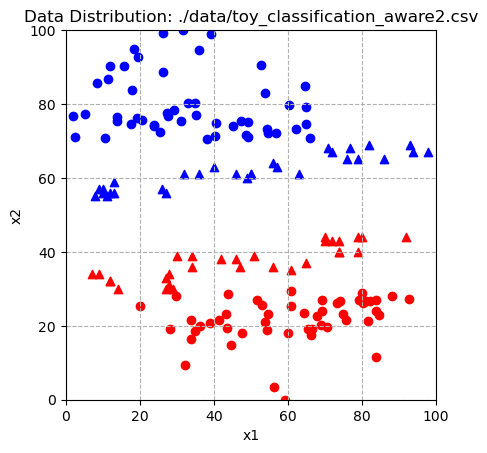

Training:   0%|          | 0/300 [00:00<?, ?it/s]

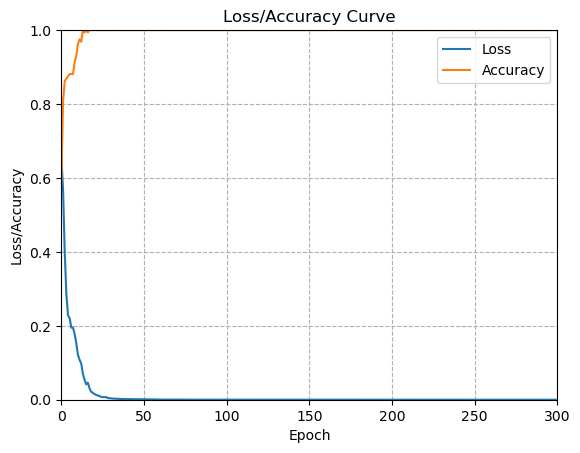

Training:   0%|          | 0/300 [00:00<?, ?it/s]

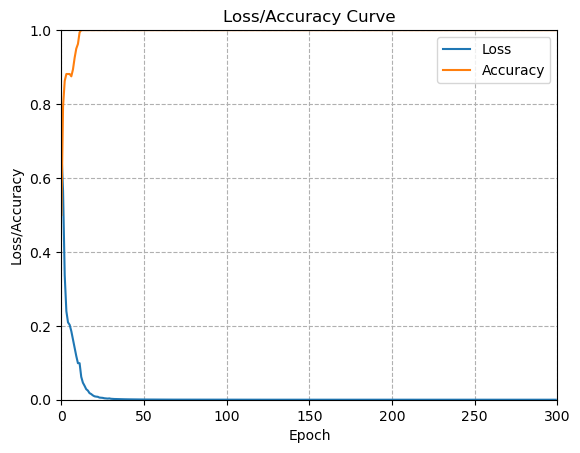

Training:   0%|          | 0/300 [00:00<?, ?it/s]

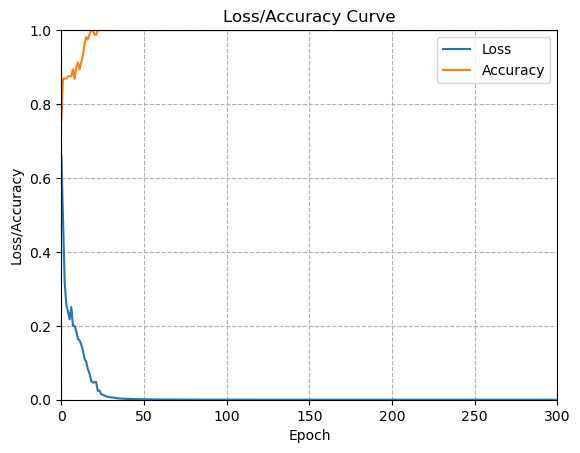

Training:   0%|          | 0/300 [00:00<?, ?it/s]

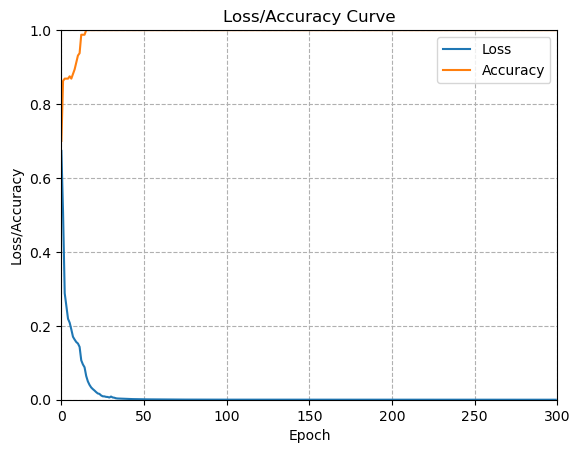

Training:   0%|          | 0/300 [00:00<?, ?it/s]

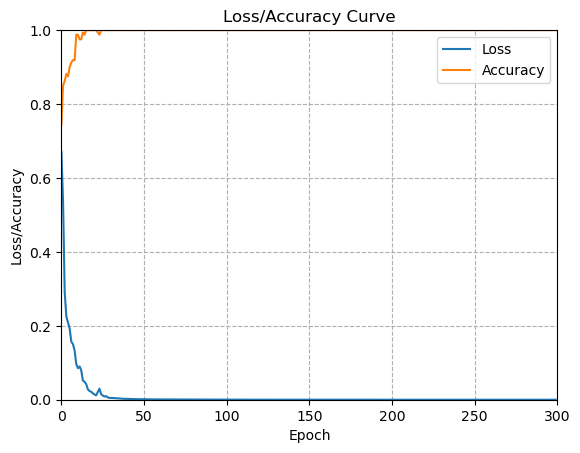

Training:   0%|          | 0/300 [00:00<?, ?it/s]

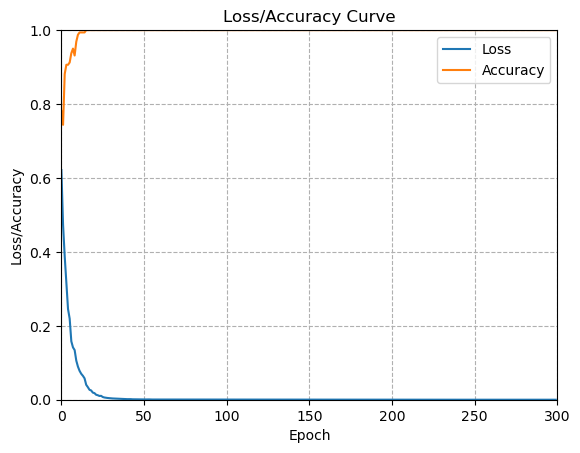

Training:   0%|          | 0/300 [00:00<?, ?it/s]

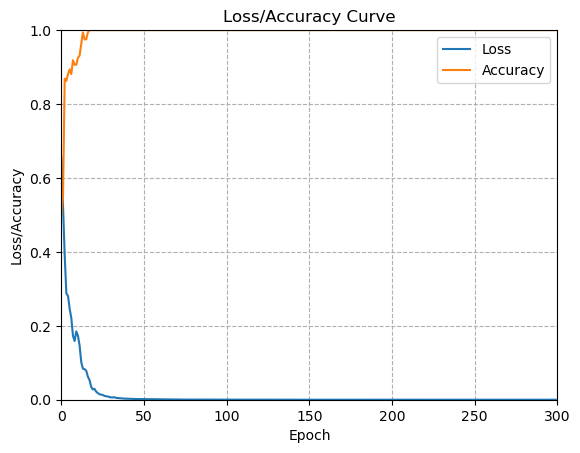

Training:   0%|          | 0/300 [00:00<?, ?it/s]

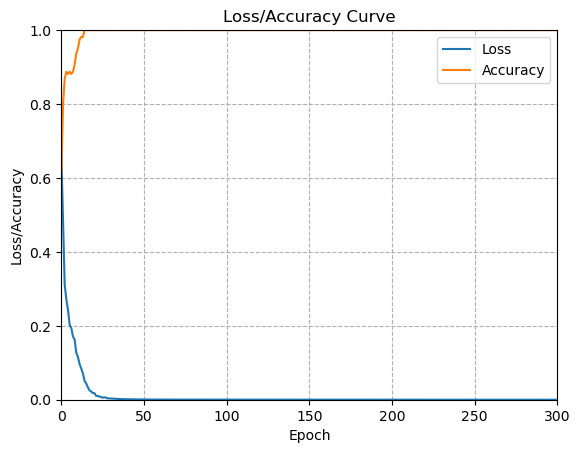

Training:   0%|          | 0/300 [00:00<?, ?it/s]

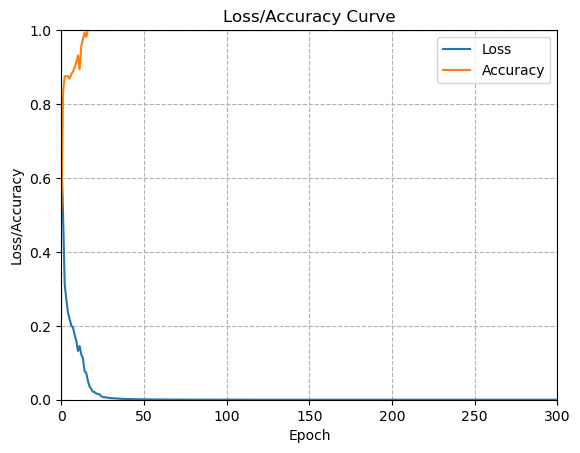

Training:   0%|          | 0/300 [00:00<?, ?it/s]

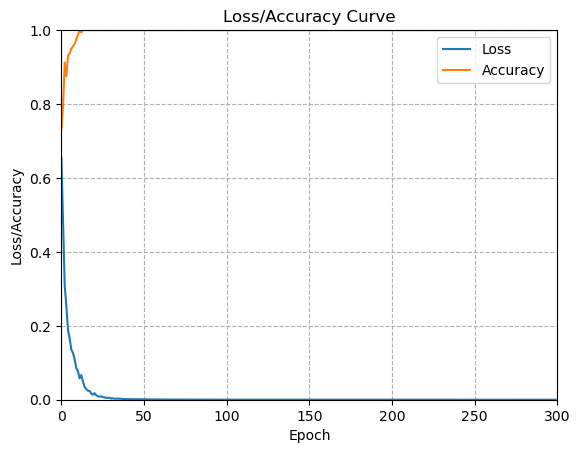

Training:   0%|          | 0/300 [00:00<?, ?it/s]

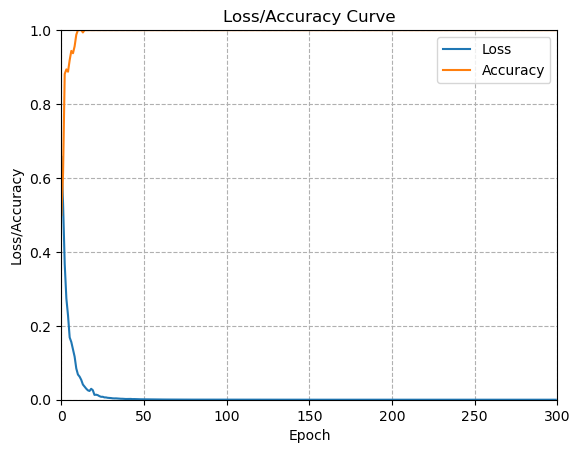

Training:   0%|          | 0/300 [00:00<?, ?it/s]

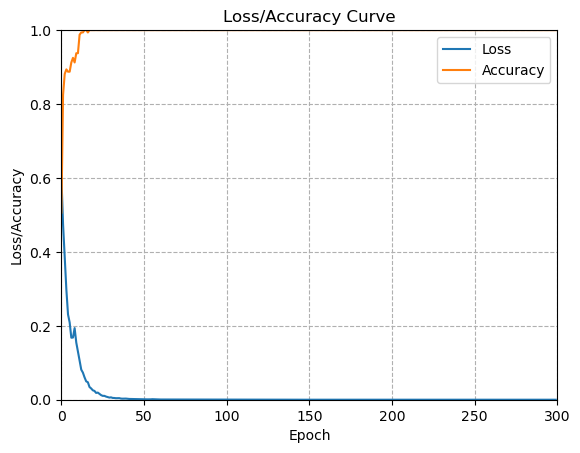

Training:   0%|          | 0/300 [00:00<?, ?it/s]

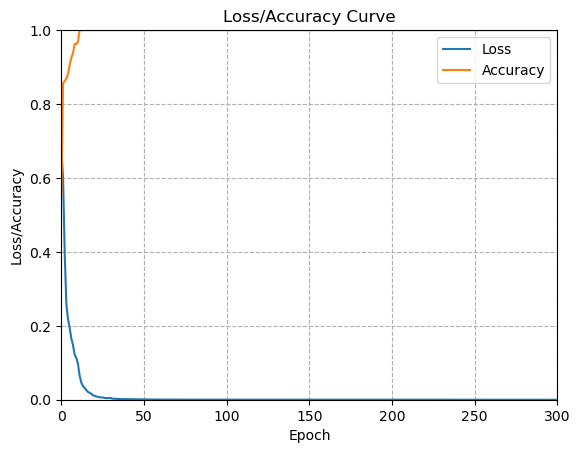

Training:   0%|          | 0/300 [00:00<?, ?it/s]

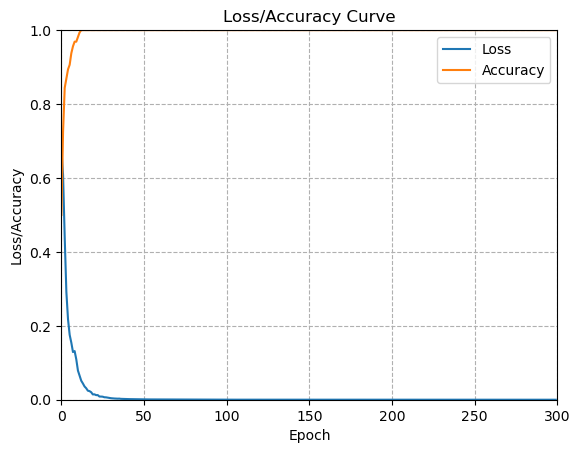

Training:   0%|          | 0/300 [00:00<?, ?it/s]

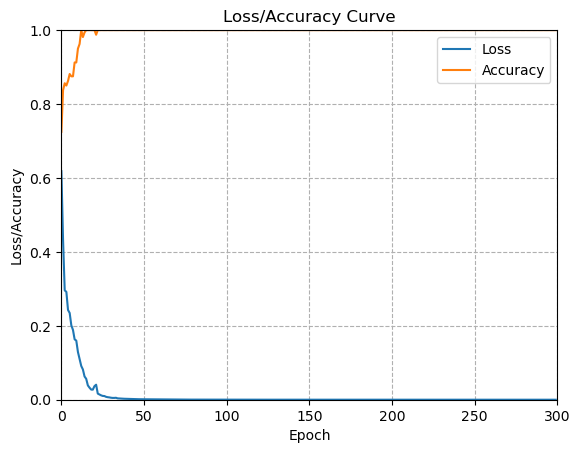

Training:   0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
# Using multiple seed values
seed_list = [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
model_list = []

dataset = ToyDataset(hyperparameters['data_path'])
for seed in seed_list:
    set_seed(seed)

    # Initialize the dataset and model
    model = ToyModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])

    # Train the model
    train(model, dataset, criterion, optimizer, hyperparameters['batch_size'], hyperparameters['epochs'], device)
    model_list.append(model)

Saving the figure as toy_classification_clean2_2023-Mar-17-16:17:50.png


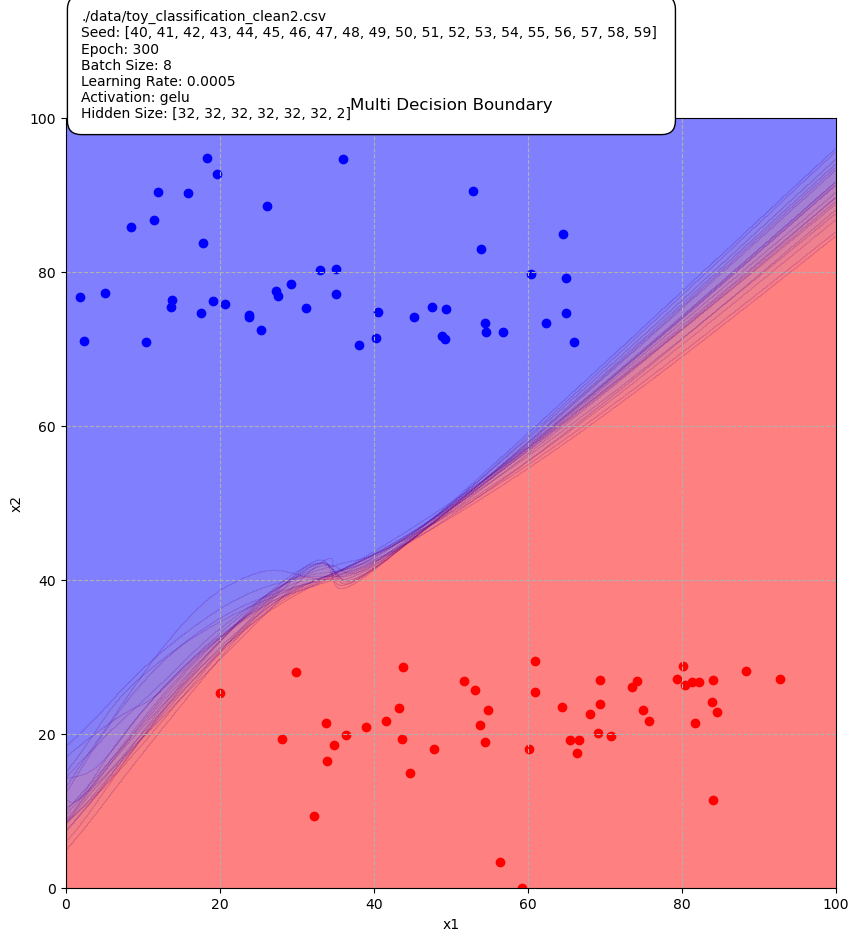

In [ ]:
# Visualize multiple decision boundaries
def visualize_multi_decision_boundary(seed_list: list, model_list: list, device: torch.device) -> None:
    # Visualize the decision boundary
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    y_list = []

    for model in model_list:
        x1, x2 = np.meshgrid(np.arange(0, 100, 0.1), np.arange(0, 100, 0.1))
        X = np.c_[x1.ravel(), x2.ravel()]
        X = torch.tensor(X, dtype=torch.float).to(device)
        with torch.no_grad():
            y = model(X)
        y = y.argmax(1).cpu().numpy()
        y = y.reshape(x1.shape)
        y_list.append(y)
    
    for y in y_list:
        ax.contourf(x1, x2, y, alpha=0.03, cmap=ListedColormap(hyperparameters['colors'].values()))

    for i in range(len(dataset.dataframe)):
        if dataset.dataframe.iloc[i, 3] == 0:
            ax.scatter(dataset.dataframe.iloc[i, 0], dataset.dataframe.iloc[i, 1],
                        c=hyperparameters["colors"][dataset.dataframe.iloc[i, 2]], marker="o")
        else:
            ax.scatter(dataset.dataframe.iloc[i, 0], dataset.dataframe.iloc[i, 1],
                        c=hyperparameters["colors"][dataset.dataframe.iloc[i, 2]], marker="^")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_title(f"Multi Decision Boundary")
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_aspect("equal")
    ax.grid(True, which="both", ls="--")

    ax.text(2, 100,
            # Multi-line text
            f"{hyperparameters['data_path']}\n" + \
            f"Seed: {seed_list} \n" + \
            f"Epoch: {hyperparameters['epochs']} \n" + \
            f"Batch Size: {hyperparameters['batch_size']} \n" + \
            f"Learning Rate: {hyperparameters['learning_rate']} \n" + \
            f"Activation: {hyperparameters['activation']} \n" + \
            #f"Dropout: {hyperparameters['dropout']} \n" + \
            f"Hidden Size: {hyperparameters['hidden_size']}",
            
            fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1')
    )

    timestep = time.strftime('%Y-%b-%d-%H:%M:%S', time.localtime())
    print(f"Saving the figure as {hyperparameters['data_name'][:-4] + '_' + timestep + '.png'}")
    plt.savefig(f"./output/{hyperparameters['data_name'][:-4] + '_' + timestep + '.png'}")
    plt.show()

# Visualize the decision boundary after training
visualize_multi_decision_boundary(seed_list, model_list, device)